## Présentation

Twitter est un réseau social permettant aux utilisateurs de publier des informations et communiquer entre eux par le biais de messages, appelés tweets, pouvant contenir jusqu'à 280 caractères. Largement utilisé aujourd'hui, ce réseau peut être un outil pour des entreprises qui souhaitent évaluer l'avis de leurs clients.

Dans ce TP, on se met à la place d'une compagnie aérienne, qui souhaiterait détecter les tweets qui la mentionnent et analyser si ce sont des mentions positives ou négatives, en comparant leur résultat avec les autres compagnies.

Le *preprocessing* est une tâche cruciale en fouille de données. Elle permet de transformer les données brutes en un format adapté à l'application de méthodes de machine learning.

# INF8111 - Fouille de données


## TP1 Automne 2019 - Preprocessing de tweets pour de l'analyse de sentiments

##### Membres de l'équipe:

    - Amine Bellahsen
    - Abderrahim Khalifa
    - Hamza Sghir

# I/ Analyse de sentiments (13 Pts)

Usuellement dans la littérature, la tâche d'extraire le sentiment d'un texte est appelé *sentiment analysis*.
Ici pour se faire, nous allons utiliser un modèle *bag-of-words* (BoW).

## 1. Installation

Pour ce TP, vous aurez besoin des librairies `numpy`, `sklearn` et `scipy` (que vous avez sans doute déjà), ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et exécutez le code ci-dessous :

In [1]:
# If you want, you can use anaconda and install after nltk library
# !pip install --user numpy
# !pip install --user sklearn
# !pip install --user scipy
# !pip install --user nltk

import sys
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download('words')


[nltk_data] Downloading package punkt to /home/aminebe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aminebe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aminebe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/aminebe/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package words to /home/aminebe/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## 2. Jeu de données

On utilise un jeu de donnée provenant de *Crowdflower's Data for Everyone library*: https://www.figure-eight.com/data-for-everyone/

Pour citer la source originale de la base :

    A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

Les compagnies incluses dans cette base de données sont Virgin America, United Airline, Southwest Airlines, jetBlue, USAirways, et American Airlines.

Dans le fichier zip du TP, vous trouverez le fichier *airline_tweets_database.csv*, qui est la base de données de tweets que nous allons manipuler.

Chaque ligne de ce fichier contient un tweet, avec plusieurs informations : l'identifiant du tweet, l'utilisateur, le contenu, le nombre de retweet... Ainsi que le label.

3 labels différents sont possibles dans ce dataset : *négatif*, *neutre* et *positif*, que l'on va représenter respectivement par 0, 1 et 2.

Pour ce TP, on ne va conserver ici que le texte et le label. On divise ensuite la base de données en 3 ensembles (entrainement/validation/test). Vous utiliserez l'ensemble d'entraînement et de validation pour cette partie, et l'ensemble de test à la partie suivante.

Le code ci-dessous permet de charger ces ensembles:

In [2]:
import csv
from sklearn.model_selection import train_test_split

def load_dataset(path):
    
    x = []
    y = []

    with open(path, 'r', newline='', encoding="latin-1") as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        ind_label = header.index('airline_sentiment')
        ind_text = header.index('text')
        
        for row in reader:
            x.append(row[ind_text])
            
            label = row[ind_label]
            
            if label == "negative":
                y.append(0)
            elif label == "neutral":
                y.append(1)
            elif label == "positive":
                y.append(2)

        assert len(x) == len(y)

        return x, y


# Path of the dataset
path = "data/airline_tweets_database.csv"

X, y = load_dataset(path)

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))


Length of training set :  10204
Length of validation set :  2240
Length of test set :  2196


## 3. Preprocessing

Nous allons ici implémenter la *tokenization* et le *stemming*, qui sont 2 étapes courantes de preprocessing en NLP. Ensuite, afin d'avoir un modèle qui s'adapte mieux au format de Twitter, nous ajouterons une étape spécifique supplémentaire.

### 3.1. Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple la phrase *"It's the student's notebook."* peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].

**De plus, tous les tokenizers ont également le rôle de mettre le texte en minuscule.**


##### Question 1. Implémentez les 2 tokenizers différents suivants: (0.5 Pts)

- Le **SpaceTokenizer**, qui est un tokenizer naïf qui sépare simplement en fonction des espaces.
- Le **NLTKTokenizer**, qui utilise la méthode du package *nltk* (https://www.nltk.org/api/nltk.html).


In [465]:
from nltk.tokenize import TweetTokenizer

class SpaceTokenizer(object):
    """
    It tokenizes the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.

    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """

    def tokenize(self, text):
        # Have to return a list of tokens
        tokens = text.split()
        return tokens


class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """

    def tokenize(self, text):
        # Have to return a list of tokens
        tokens = nltk.tokenize.word_tokenize(text)
        return tokens


#### Testez les deux tokenizers. Quelles différences pouvez-vous constater?

In [466]:
text = "It's the student's notebook."

print("Testing with SpaceTokenizer")
spaceTokenizer = SpaceTokenizer()
print(spaceTokenizer.tokenize(text))

print("\n")

print("Testing with NLTKTokenizer")
nltkTokenizer = NLTKTokenizer()
print(nltkTokenizer.tokenize(text))

Testing with SpaceTokenizer
["It's", 'the', "student's", 'notebook.']


Testing with NLTKTokenizer
['It', "'s", 'the', 'student', "'s", 'notebook', '.']


### 3.2. Troncature (ou Stemming)

Dans les phrases "I should have bought a new shoes today" et "I spent too much money buying games", les mots "buying" et "bought" représentent la même idée. Considérer ces deux mots comme différents ne ferait qu'augmenter pour rien la complexité et la dimension du problème, ce qui peut avoir un impact négatif sur la performance globale. Ainsi, on peut donc plutôt une forme unique (comme la racine du mot) pour représenter ces deux mots de la même manière. Ce procédé de conversion de mots en racines permettant de réduire la dimension est appelé usuellement *stemming*, que l'on peut traduire par troncature.


#### Question 2. Récupérez les troncatures des tokens en utilisant l'attribut *stemmer* de la classe *Stemmer* (0.5 Pts) 

In [5]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, token):
        """
        token: a string that contain a token
        """
        # Have to return the stemmed token
        return list(map(self.stemmer.stem,token))


In [6]:
stemmer = Stemmer()
print(stemmer.stem(["buying", "doing"]))

['buy', 'doing']


### 3.3. Twitter preprocessing

Parfois, appliquer uniquement ces deux étapes ne suffit pas, due aux particularités des données que nous manipulons, qui peuvent demander des étapes de preprocessing spécifiques afin d'obtenir un modèle plus adapté.

Couramment en NLP, un dictionnaire est utilisé pour stocker un ensemble de mots, et tous les mots n'appartenant pas au dictionnaire sont considérés comme inconnus. Ainsi, avec ce choix d'implémentation, la dimension de l'espace caractéristique du modèle est directement liée au nombre de mots du dictionnaire. Ainsi, pour des raisons de complexité mais aussi car les modèles à trop grande dimension peuvent souffrir du fléau de la dimensionnalité, il est préférable de réduire la taille de notre vocabulaire.

#### Question 3. Donnez, en expliquant brièvement, au moins deux exemples d'étapes de préprocessing qui permettent de réduire la taille du dictionnaire ici, puis implémentez-les.  (2.0 points)

Ces étapes de préprocessing doivent être en rapport aux charactéristiques spécifiques des données de Twitter. La suppression des mots vides ne compte pas comme une des deux étapes.

L'etape du preprocessing est une étape crutial pour le developement d'un modele assez puissant. On propose ici quelques traitements qu'on efectuera sur les tweet afin de reduire le vocabulaire et supprimer les tokens qui ne servent pas à notre problematique:

- **Remplacer les URL par un token:** les url sur twitter sont tous reduit vers un lien t.co qui ne donnent pas generalement aucune idée sur le contenu du tweet. On replace tous les url dans les tweet par le token `__URL__`

- **Remplacer les nombres par un token:** Un nombre ne permet pas dans un model BoW de savoir c'est quoi la nature du tweet sauf si on le met dans un context en specifiant l'unitée par exemple. On replace tous les nombre dans les tweet par le token `__NBR__`

- **Remplacer les TAGs par un token:** Lorsqu'on tag quelqu'un sur un tweet cela ne serve pas beaucoup à savoir l'emotion qu'on exprime. On replace tous les TAG ( les token qui commencent par @) dans les tweet par le token `__UNAME__`

- **Enlever les # des hashtags:** On va considerer les hashtags comme des mots.

- **Traiter les emojis**: Il s'agit ici de classifer les emojis, au moins les plus utilisés, selon deux categories: positives et negatives. Ceci permettra d'avoir une idée sur le type d'emotion exprimé dans le tweet, en remplacant soit par `EMO_POS` qui signifie emotion positive ou `EMO_NEG` qui signifie emotion negative. le code pour ce traitement on l'a depuis ce [lien](https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/code/preprocess.py?fbclid=IwAR2D44a0pwGWAhxsUVP0Gvr9EpRqd11qAgBXyfpp796mkCJPDXRraPurfu8).

In [350]:
import string
import re

In [619]:
class TwitterPreprocessing(object):

    def handle_urls(self, tweet):
        tweet = re.sub(r'(https:|http:)?\/\/t.co\/[a-zA-Z0-9]+', ' __URL__ ', tweet)
        return tweet
    
    def handle_numbers(self, tweet):
        tweet = re.sub(r'\b\d+\b', ' __NBR__ ', tweet)
        return tweet
        
    def handle_tags(self, tweet):
        tweet = re.sub(r'@\S+', ' __UNAME__ ', tweet)
        return tweet
    
    def handle_hashtags(self, tweet):
        tweet = re.sub(r'#(\S+)', r'\1', tweet)
        return tweet

    def handle_and(self, tweet):
        return tweet.replace("&amp;", "&")
    
    def handle_emojis(self, tweet):
        # taken from https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/code/preprocess.py
        # Smile --
        tweet = re.sub(r'(:-\)|\(-:|:\'\))', ' __EMO_POS__ ', tweet)
        # Laugh -- 
        tweet = re.sub(r'(:-?D|x-?D|X-?D)', ' __EMO_POS__ ', tweet)
        # Love -- 
        tweet = re.sub(r'(<3|:\*)', ' __EMO_POS__ ', tweet)
        # Wink -- 
        tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' __EMO_POS__ ', tweet)
        # Sad -- 
        tweet = re.sub(r'(:-\(|\)-:)', ' __EMO_NEG__ ', tweet)
        # Sad 2 -- 
        tweet = re.sub(r'(:\/|:-\/)', ' __EMO_NEG__ ', tweet)
        # Cry -- 
        tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' __EMO_NEG__ ', tweet)
        return tweet

    def preprocess(self,data):
        
        data=self.handle_urls(data)
        data=self.handle_emojis(data)
        data=self.handle_tags(data)
        data=self.handle_hashtags(data)
        data=self.handle_and(data)
        # remove single letters and some repeated punctuation
        data = re.sub(r'\b[-\']\b', '', data)
        data = re.sub(r'\b\w\b', '', data)
        data = re.sub(r'[\?\'\.]{2,}', ' ', data)
        # remove encoding chars
        data = data.encode("cp1251","ignore").decode("utf8")
        return data

In [620]:
# test
text = "Hello world \x8f this is my first &amp; tweet 2019!poke @Hamza0, @Amine #LetsMakePolyGreatAgain :D ;) :-) :-D :-/ :/ meet us @ //t.co/kbb0B5FxMK https://t.co/gooNdg00Poly"
tweet_prep = TwitterPreprocessing()
tweet_prep.preprocess(text)

'Hello world  this is my first & tweet 2019!poke  __UNAME__   __UNAME__  LetsMakePolyGreatAgain  __EMO_POS__   __EMO_POS__   __EMO_POS__   __EMO_POS__   __EMO_NEG__   __EMO_NEG__  meet us @  __URL__   __URL__ '

d'autres traitements peuvent être envisagés comme le traitement des ponctuations et les espaces.

### 3.4.  Pipeline

Une pipeline permet d'exécuter séquentiellement toutes les étapes de preprocessing, pour transformer les données brutes en une version utilisable pour notre modèle. La *PreprocessingPipeline* a été implémenter pour appliquer à la suite le tokenizer, les troncatures et le preprocessing spécifique à Twitter. 

**N'hésitez pas à changer l'ordre des étapes de preprocessing si vous le souhaitez.**

In [564]:
class PreprocessingPipeline:

    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer = NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing(
        ) if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """
        if self.twitterPreprocesser:
            tweet_processed = self.twitterPreprocesser.preprocess(tweet)
        else:
            tweet_processed = tweet
        
        tokens = self.tokenizer.tokenize(tweet_processed)
        if self.stemmer:
            tokens = self.stemmer.stem(tokens)
        return tokens


Test de la pipeline :

In [427]:
print("initial tweet:",train_X[:1])
pipeline = PreprocessingPipeline(tokenization=True, twitterPreprocessing=True, stemming=True)
print("results:")
print(list(map(pipeline.preprocess, train_X[:1])))

initial tweet: ['@USAirways tells me to talk to @AmericanAir about my delayed flights. AA tells me to talk to US. #ihatemergers']
results:
[['__uname__', 'tell', 'me', 'to', 'talk', 'to', '__uname__', 'about', 'my', 'delay', 'flight', '.', 'aa', 'tell', 'me', 'to', 'talk', 'to', 'us', '.', 'ihatemerg']]


## 4. N-grams

Un n-gram est une séquence continue de *n* tokens dans un texte. Par exemple, les séquences *"nous a"* et *"la porte"* sont deux exemples de 2-grams de la phrase *"Il nous a dit au revoir en franchissant la porte."*. 1-gram, 2-gram et 3-gram sont respectivement appelés unigram, bigram et trigram. 

Voici la liste de tous les unigrams, bigrams et trigrams possible pour la phrase *"Il nous a dit au revoir en franchissant la porte."* :
- Unigram: ['Il', 'nous', 'a', 'dit', 'au', 'revoir', 'en', 'franchissant', 'la', 'porte']
- Bigram: ['Il nous', 'nous a', 'a dit', 'dit au', 'au revoir', 'revoir en', 'en franchissant', 'franchissant la', 'la porte']
- Trigram: ['Il nous a', 'nous a dit', 'a dit au', 'dit au revoir', 'au revoir en', 'revoir en franchissant', 'en franchissant la', 'franchissant la porte']


##### Question 4. Implementez les fonctions `bigram` et `trigram`. (1 Pt)

Vous devez résoudre cette question sans utiliser de libraire exterieur comme scikit-learn par exemple.

In [456]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    bigrams = []
    for words in zip(tokens[:-1],tokens[1:]):
        bigrams.append(" ".join(words))
    # This function returns the list of bigrams
    return bigrams


def trigram(tokens):
    """
    tokens: a list of strings
    """
    trigrams = []
    for words in zip(tokens[:-2],tokens[1:-1], tokens[2:]):
        trigrams.append(" ".join(words))
    # This function returns the list of trigrams
    return trigrams


In [429]:
text = "He does not know what he is talking about"
nltktokenizer = NLTKTokenizer()
tokens = nltktokenizer.tokenize(text)
print('Liste des bigrams :'+"\n")
print('Bigrams =', bigram(tokens))
print('\n')
print('Liste des trigrams :'+"\n")
print('Trigrams = ', trigram(tokens))

Liste des bigrams :

Bigrams = ['He does', 'does not', 'not know', 'know what', 'what he', 'he is', 'is talking', 'talking about']


Liste des trigrams :

Trigrams =  ['He does not', 'does not know', 'not know what', 'know what he', 'what he is', 'he is talking', 'is talking about']


## 5. Bag-of-words

Régressions logistiques, SVM et d'autres modèles très courants demande des entrées qui soient toutes de la même taille, ce qui n'est forcément le cas pour des types de données comme les textes, qui peuvent avoir un nombre variable de mots.  

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Pandemic is an awesome game!”. La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe : 

|<i></i>     | an | are | ! | pandemic | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne représente un mot du vocabulaire (de longueur 13), tandis que chaque ligne contient l'occurence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au fait que le mot *"games"* apparait deux fois dans la phrase 1. 

Ainsi, chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. Ainsi, c'est cette méthode que l'on appelle *Bag-of-Words* : c'est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construit en comptant le nombre d'occurence de chaque mot. Ainsi, chaque token est ici associé à une dimension.


##### Question 5. Implémentez le Bag-of-Words (2 Pts)

Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn, hormis si vous avez des problèmes de mémoire, vous pouvez utiliser la classe sparse.csr_matrix de scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

In [430]:
# no need for the csr_matrix if we use an np.int8 type 
# (we suppose the tweet are not too long and cannot contain the same token more than 256 times)
from scipy.sparse import csr_matrix
import numpy as np

class CountBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None

        
    def computeBoW(self, tokens):
        """
        Calcule du BoW, à partir d'un dictionnaire de mots et d'une liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire sur l'ensemble d'entraînement.
        
        Entrée: tokens, une liste de vecteurs contenant les tweets (une liste de liste)
        
        Return: une csr_matrix
        """
        
        
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )
        
        word_to_idx = {word:idx for idx,word in enumerate(self.words)}
        
        bag_matrix = np.zeros((len(tokens), len(self.words)),dtype=np.int8)
        
        for tweet_idx,tweet_tokens in enumerate(tokens):
            all_tokens = tweet_tokens.copy()
            if self.bigram == True :
                all_tokens+=bigram(tweet_tokens)
            if self.trigram == True :
                all_tokens+=trigram(tweet_tokens)
                
            for token in all_tokens:
                word_idx = word_to_idx.get(token, -1)
                if word_idx>=0:
                    bag_matrix[tweet_idx,word_to_idx[token]] += 1
        
        return bag_matrix
        

    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs d'entiers.
        
        Entrée: X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        
        toknized_tweets = list(map(self.pipeline.preprocess, X))
        words_dictionnary = set()
        for tweet in toknized_tweets:
            for token in tweet:
                words_dictionnary.add(token)
            if self.bigram == True :
                for token in bigram(tweet):
                    words_dictionnary.add(token)
            if self.trigram == True :
                for token in trigram(tweet):
                    words_dictionnary.add(token)
                    
        self.words = list(words_dictionnary)
        
        return self.computeBoW(toknized_tweets)
        
    
    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs d'entiers.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire ici

        Entrée: X, une liste de vecteurs contenant les tweets
        Return: une csr_matrix
        """
        
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        toknized_tweets = list(map(self.pipeline.preprocess, X))
        return self.computeBoW(toknized_tweets)
            
        


In [431]:
pipeline = PreprocessingPipeline(tokenization=True, twitterPreprocessing=True, stemming=True)
bow_test=CountBoW(pipeline, bigram=True, trigram=True)
bow_test.fit_transform(train_X[:2])

array([[0, 4, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 0,
        0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 2, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]], dtype=int8)

In [432]:
list_list= bow_test.transform(train_X[3:5])
list_list

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

## 6. TF-IDF

L'utilisation de la fréquence d'apparition brute des mots, comme c'est le cas avec le bag-of-words, peut être problématique. En effet, peu de tokens auront une fréquence très élevée dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance à biaiser l'ensemble des poids. De plus, les mots qui apparaissent dans la plupart des documents n'aident pas à les discriminer. Par exemple, le mot "*de*" apparaît dans beaucoup de tweets de la base de données, et pour autant, avoir ce mot en commun ne permet pas de conclure que des tweets sont similaires. Au contraire, le mot "*génial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'être positif. TF-IDF est donc une méthode qui permet de pallier à ce problème.

TF-IDF pondère le vecteur en utilisant une fréquence de document inverse (IDF) et une fréquence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donné, tandis que IDF mesure la capacité de discrimination des mots dans un jeu de données. 

L'IDF d'un mot se calcule de la façon suivante:

\begin{equation}
	\text{idf}_i = \log\left( \frac{N}{\text{df}_i} \right),
\end{equation}

avec $N$ le nombre de documents dans la base de donnée, et $\text{df}_i$ le nombre de documents qui contiennent le mot $i$.

Le nouveau poids $w_{ij}$ d'un mot $i$ dans un document $j$ peut ensuite être calculé de la façon suivante:

\begin{equation}
	w_{ij} = \text{tf}_{ij} \times \text{idf}_i,
\end{equation}

avec $\text{tf}_{ij}$ la fréquence du mot $i$ dans le document $j$.




##### Question 6. Implémentez le bag-of-words avec la pondération de TF-IDF (3 Pts)

Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn, hormis si vous avez des problèmes de mémoire, vous pouvez utiliser la classe sparse.csr_matrix de scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

In [433]:
from scipy.sparse import csr_matrix
import math


class TFIDFBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        idf: list of idfs for each document
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None
        self.idf = None
    
    def computeTFIDF(self, tokens):
        """
        Calcule du TF-IDF, à partir d'un dictionnaire de mots et d'une 
        liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire ainsi que 
        calculé le vecteur contenant l'idf pour chaque document.
        
        Entrée: tokens, une liste de vecteurs contenant les tweets (une liste de liste)
        
        Return: une csr_matrix
        """
        
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )
            
        word_to_idx = {word:idx for idx,word in enumerate(self.words)}
        
        tf = np.zeros((len(tokens), len(self.words)),dtype=np.int8)
        
        for tweet_idx,tweet_tokens in enumerate(tokens):
            all_tokens = tweet_tokens.copy()
            if self.bigram == True :
                all_tokens+=bigram(tweet_tokens)
            if self.bigram == True :
                all_tokens+=trigram(tweet_tokens)
                
            for token in all_tokens:
                word_idx = word_to_idx.get(token, -1)
                if word_idx>=0:
                    tf[tweet_idx,word_to_idx[token]] += 1

        # puisque ce n'est pas specifié on utilise le np.log
        if self.idf is None:
            self.idf = np.log(tf.shape[0] / (tf!=0).sum(axis=0))
        
        return np.multiply(tf, self.idf)


    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        toknized_tweets = list(map(self.pipeline.preprocess, X))
        words_dictionnary = set()
        for tweet in toknized_tweets:
            for token in tweet:
                words_dictionnary.add(token)
            if self.bigram == True :
                for token in bigram(tweet):
                    words_dictionnary.add(token)
            if self.trigram == True :
                for token in trigram(tweet):
                    words_dictionnary.add(token)
                    
        self.words = list(words_dictionnary)
        return self.computeTFIDF(toknized_tweets)
    
    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire et du calcul des idf ici.
            
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        toknized_tweets = list(map(self.pipeline.preprocess, X))
        return self.computeTFIDF(toknized_tweets)
    

In [434]:
pipeline = PreprocessingPipeline(tokenization=True, twitterPreprocessing=True, stemming=True)
tfidf_test=TFIDFBoW(pipeline, bigram=False, trigram=False)
tfidf_test.fit_transform(train_X[:2])

array([[0.        , 0.        , 0.        , 1.38629436, 2.77258872,
        0.69314718, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.69314718, 0.        ,
        0.        , 0.69314718, 0.        , 0.        , 1.38629436,
        0.        , 0.        , 0.69314718, 0.        , 0.69314718,
        0.        , 1.38629436, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.69314718, 0.        , 0.        ,
        0.        , 0.69314718],
       [0.69314718, 0.69314718, 0.69314718, 0.        , 0.        ,
        0.        , 0.69314718, 0.69314718, 0.        , 0.        ,
        0.69314718, 0.69314718, 0.69314718, 0.        , 0.69314718,
        0.69314718, 0.        , 0.69314718, 0.69314718, 0.        ,
        1.38629436, 0.69314718, 0.        , 0.69314718, 0.        ,
        0.69314718, 0.        , 0.69314718, 0.69314718, 1.38629436,
        0.69314718, 0.69314718, 0.        , 0.69314718, 0.69314718,
        0.69314

In [435]:
list_list= tfidf_test.transform(train_X[3:5])
list_list

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.69314718, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.69314718, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.69314718, 0.69314718],
       [0.        , 0.        , 0.        , 0.        , 2.07944154,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.38629436, 0.        , 0.        , 0.69314718, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.69314718, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.     

## 7. Classification utilisant BoW

Pour la classification, nous allons effectuer une régression logisitique (vu en cours ou que vous allez voir bientôt). 
Pour en savoir plus : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

La méthode `train_evaluate` entraîne et évalue le modèle de régression logistique.


In [436]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    classifier = LogisticRegression(n_jobs=-1)

    training_rep = bowObj.fit_transform(training_X)
    print("- Taille du dictionnaire:",len(bowObj.words))
    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.transform(validation_X)))
    
    print(f"- Training accuracy: {trainAcc:.5f}")
    print(f"- Validation accuracy: {validationAcc:.5f}")
    return classifier, trainAcc, validationAcc



##### Question 7. Entraînez et calculez la précision de la régression logistique sur les ensembles d'entraînement et de validation. (4 points)

Essayez les configurations suivantes :

    1. CountBoW + SpaceTokenizer(without tokenizer) + unigram 
    2. CountBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
    4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
    5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
    6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram

Outre la précision, reportez la taille du dictionnaire pour chacune des configurations. Enfin, décrivez vos résultats obtenus et répondez aux questions suivantes:
- Quelles étapes de preprocessing ont effectivement aidé le modèle ? Pourquoi ?
- La pondération avec TF-IDF a-t-elle aidé à obtenir une meilleure performance que le simple BoW ?
- Les bigrams et trigrams ont-ils amélioré la performance ? Expliquez pourquoi.

Indiquez quelle est la configuration que vous choisissez.

In [467]:
configurations = [
    {"model":CountBoW, "tokenize":False},
    {"model":CountBoW, "tokenize":True},
    {"model":TFIDFBoW, "tokenize":True, "stemming": True},
    {"model":TFIDFBoW, "tokenize":True, "stemming": True, "preprocess":True},
    {"model":TFIDFBoW, "tokenize":True, "stemming": True, "preprocess":True, "bi":True},
    {"model":TFIDFBoW, "tokenize":True, "stemming": True, "preprocess":True, "bi":True,"tri":True}
]

results = []
for i,conf in enumerate(configurations):
    print(f"[+] Running configuration {i+1}...")
    stemming = conf.get("stemming",False)
    tw_prep = conf.get("preprocess",False)
    tokenize = conf.get("tokenize",False)
    
    pipeline = PreprocessingPipeline(tokenization = tokenize, twitterPreprocessing = tw_prep, stemming = stemming)
    obj = conf["model"](pipeline, bigram = conf.get("bi",False), trigram = conf.get("tri",False))
    results.append(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y, obj))

#- Taille du dictionnaire: 11064
#- Training accuracy: 0.98844
#- Validation accuracy: 0.94873

[+] Running configuration 1...
- Taille du dictionnaire: 23071


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


- Training accuracy: 0.96139
- Validation accuracy: 0.93161
[+] Running configuration 2...
- Taille du dictionnaire: 15540


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


- Training accuracy: 0.94277
- Validation accuracy: 0.91763
[+] Running configuration 3...
- Taille du dictionnaire: 11064


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


- Training accuracy: 0.98844
- Validation accuracy: 0.94873
[+] Running configuration 4...
- Taille du dictionnaire: 9282


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


- Training accuracy: 0.98256
- Validation accuracy: 0.94511
[+] Running configuration 5...
- Taille du dictionnaire: 79244


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


- Training accuracy: 0.99647
- Validation accuracy: 0.96255
[+] Running configuration 6...
- Taille du dictionnaire: 211105


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


- Training accuracy: 0.99667
- Validation accuracy: 0.96183


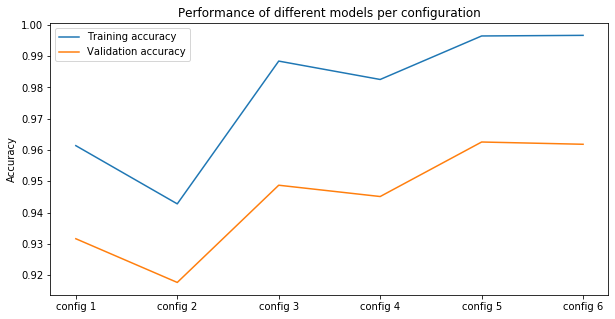

In [438]:
import matplotlib.pyplot as plt
%matplotlib inline

models, training_acc, validation_acc = zip(*results)

plt.figure(figsize=(10,5))
plt.plot(list(map(lambda i:f"config {i}",range(1,7))), training_acc, label="Training accuracy")
plt.plot(list(map(lambda i:f"config {i}",range(1,7))), validation_acc, label="Validation accuracy")
plt.title("Performance of different models per configuration")
plt.ylabel("Accuracy")
plt.legend();

- Quelles étapes de preprocessing ont effectivement aidé le modèle ? Pourquoi ?

Selon les résultats des différentes configuration de preprocessing ci-dessous, nous constatons que les étapes de preprocessing de la configuration 5 qu’ont effectivement aidé le modèle. En premier lieu, l'ajout du Twitter preprocessing augmente notre précision, ce qui est logique. Ensuite, l'ajout du bigram nous aide à augmenter encore plus cette précision, puisque le modèle considère deux mots en même temps (et donc donne un contexte) et non pas chaque mot indépendamment de l'autre.


- La pondération avec TF-IDF a-t-elle aidé à obtenir une meilleure performance que le simple BoW ?


OUI, TF-IDF a donné des précisions meilleures. En outre, l’avantage de TF-IDF provient du fait que certains mots peuvent être trouvés dans différents tweets; les gens ont tendance à s'exprimer avec des caractéristiques communes (mêmes mots souvent), ce qui n'est pas pris en compte dans CountBoW, mais apparaît dans le terme IDF de TF-IDF.

- Les bigrams et trigrams ont-ils amélioré la performance ? Expliquez pourquoi.

Les bigrams et trigrams ont bien amélioré les performances. Selon les résultats, la précision sur les données de validation a augmenté de 94,5% à 96,2%  grâce à l'utilisation de bigrams. Nous pouvons en justifier par le fait que le modèle peut stocker davantage de contexte. Si nous prenons l'exemple d'un mot bigram "Don’t like" ou "Quite pleasant", cela donne plus d'informations sur le sentiment que d'avoir les deux mots séparés. Concernant les trigrams, nous pouvons avoir un à priori sur leur précision comparée aux unigrams puisqu'ils prennent en compte le contexte quand même, mais peut être que considérer deux mots à la fois marche mieux. En tout cas, c'est le cas dans cette étude puisque la configuration n°6 ne donne pas un meilleur résultat que la configuration n°5.

# II/ Prototype (7 points)

Maintenant que nous avons un modèle de classification entraîné pour l'analyse de sentiments, nous pouvons l'appliquer à notre ensemble de tests et analyser le résultat.

## 1. Analyse de Sentiments


##### Question 9. Implémentez la fonction `detect_airline` qui détecte la compagnie aérienne d'un tweet. (1,5 points)

Expliquez votre approche, et les inconvénients possibles.

**Attention :** `detect_airline` doit être en mesure de gérer le cas où aucune compagnie n'est mentionnée (auquel cas `None` est retounée), mais aussi le cas où plusieurs compagnies sont mentionnées dans un tweet.

In [471]:
from collections import Counter

knows_airlines = ['united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'virginamerica', 
                  'delta', 'spiritairlines', 'staralliance', 'virginatlantic', 'british_airways', 'expedia', 
                  'southwest', 'gma', 'silverairways', 'aircanada']

print([k[0] for k in sorted(Counter(sum(list(map(lambda x:re.findall(r"@(\w+)",x.lower()),train_X)),[])).items(), 
                            key=lambda x: -x[1]) if k[1]>2])

['united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'virginamerica', 'delta', 'imaginedragons', 'phlairport', 'ladygaga', 'carrieunderwood', 'wsj', 'dfwairport', 'flytpa', 'spiritairlines', 'fortunemagazine', 'velourlive', 'staralliance', 'love_dragonss', 'bostonlogan', 'triflight', 'virginatlantic', 'dulles_airport', 'derekc21', 'ny_njairports', 'british_airways', 'cowboycerrone', 'perfectomobile', 'fly2ohare', 'jayvig', 'expedia', 'gg8929', 'southwest', 'directtv', 'jack_kairys', 'thenationaluae', 'zkatcher', 'gma', 'ellahenderson', 'kylejudah', 'annricord', 'aarp', 'dallaslovefield', 'lasairport', 'vincenzolandino', 'jedediahbila', 'roxydigital', 'cnn', 'abcnetwork', 'nytimes', 'silverairways', 'aircanada']


In [501]:
import re
knows_airlines = ['united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'virginamerica', 
                  'delta', 'spiritairlines', 'staralliance', 'virginatlantic', 'british_airways', 'expedia', 
                  'southwest', 'gma', 'silverairways', 'aircanada']

def detect_airline(tweet):
    """
    Detect and return the airline companies mentioned in the tweet
    
    tweet: represents the tweet message. You should define the data type
    
    Return: list of detected airline companies
    """
    
    found = set(knows_airlines).intersection(re.findall(r"@(\S+)",tweet.lower()))
    return list(found) if len(found)>0 else None



##### Question 10. Implémentez la fonction `extract_sentiment` qui, à partir de tweets et d'un classificateur, extrait leurs sentiments. (0.5 points)


In [473]:

def extract_sentiment(classifier, tweets):
    """
    Extract the tweet sentiment
    
    classifier: classifier object
    tweets: represents the tweet message. processed tweets : matrix with numerical values (n_tweets x n_words)
    
    Return: list of detected airline companies
    """
    # We suppose that the classifier is trained
    return classifier.predict(tweets)


##### Question 11. En utilisant `extract_tweet_content`, `detect_airline` et `extract_sentiment`, générez un diagramme en bar contenant le nombre de tweets positives, négatifs et neutres pour chacune des compagnies. (2 points)

Décrivez brièvement le diagramme et analysez les résultats (par exemple, quelle est la compagnie avec le plus de tweets négatifs?). Expliquez comment un tel diagramme peut aider des compagnies aériennes.

In [477]:
# init configuration
selected_conf = {"model":TFIDFBoW, "tokenize":True, "stemming": True, "preprocess":True, "bi":True}

stemming = selected_conf.get("stemming",False)
tw_prep = selected_conf.get("preprocess",False)
tokenize = selected_conf.get("tokenize",False)
bi = conf.get("bi",False)
tri = conf.get("tri",False)

# init preprocessing pipeline
pipeline = PreprocessingPipeline(tokenization = tokenize, twitterPreprocessing = tw_prep, stemming = stemming)
bowObj = conf["model"](pipeline, bigram = bi, trigram = tri)

training_rep = bowObj.fit_transform(train_X)
testing_rep = bowObj.transform(test_X)

# fit the classifier
classifier = LogisticRegression(n_jobs=-1)
classifier.fit(training_rep, train_Y)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [481]:
airlines = list(map(detect_airline,test_X))
sentiments = extract_sentiment(classifier, testing_rep)

In [484]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

airlines_rates = defaultdict(lambda :defaultdict(int))
for airlines_tweet, sentim in zip(airlines, sentiments):
    if airlines_tweet is not None:
        for airln in airlines_tweet:
            airlines_rates[sentim][airln]+=1



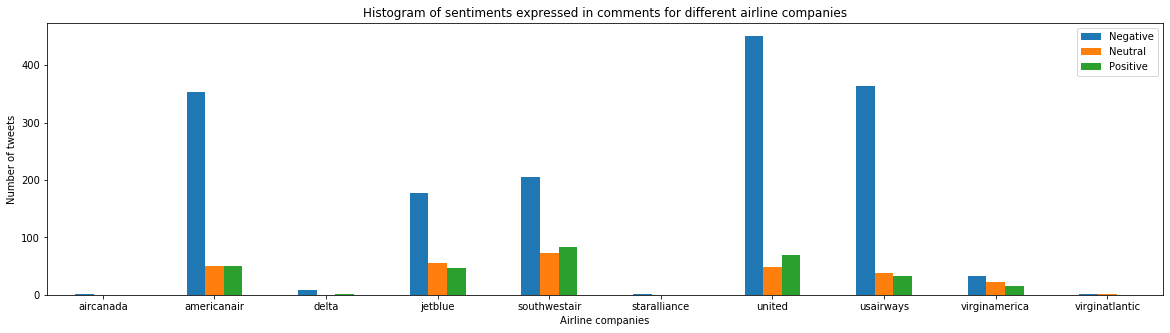

In [497]:
import pandas as pd

scores = pd.DataFrame(airlines_rates).fillna(0)
scores.columns = ["Negative", "Neutral", "Positive"]
scores.plot.bar(figsize=(20,5), rot=0)
plt.title("Histogram of sentiments expressed in comments for different airline companies")
plt.ylabel("Number of tweets")
plt.xlabel("Airline companies");

L’histogramme ci-dessus représente le nombre de tweets positives, négatifs et neutres pour chacune des compagnies. On remarque que le sentiment négatif est le plus dominant pour tous les compagnies. La compagnie United prend le dessus en terme de tweets négatifs vient après la compagnie American air, et puis UsairWays. En termes de tweets positives et neutres, on trouve qu’ils varient d’une compagnie à l’autre avec un grand écart par rapport aux tweets négatifs. 
Ce diagramme aide énormément  les compagnies aériennes pour analyser la satisfaction de leurs clients par rapport à leurs concurrents.


## 2. Analyse de termes

Le POS-tagging (pour *part-of-speech tagging*, en français étiquetage grammatical) consiste à l'extraction de l'information grammaticale d'un token dans une phrase. Par exemple, la table ci-dessous donne un exemple du *POS-tagging* de la phrase *"The cat is white!"*


|   The   | cat  |  is  | white     |    !       |
|---------|------|------|-----------|------------|
| article | noun | verb | adjective | punctation |


Pour autant, le *POS-tagging* peut être plus complexe que les règles simples apprises à l'école. Il faut souvent des informations plus détaillées sur le rôle d'un terme dans une phrase. Pour notre problème, nous n'avons pas besoin d'utiliser un modèle linguistique plus complexe, nous allons utiliser ce qu'on appelle des *POS-tags* universelles.

En *POS-tagging*, chaque token est représenté par un tag. La liste des POS-tags utilisés sont disponibles ici :
https://universaldependencies.org/u/pos/ .

In [499]:
# NLTK POS-tagger

import nltk


#before using pos_tag function, you have to tokenize the sentence.
s = ['The', 'cat', 'is',  'white', '!']
nltk.pos_tag(s,tagset='universal')


[('The', 'DET'), ('cat', 'NOUN'), ('is', 'VERB'), ('white', 'ADJ'), ('!', '.')]

##### Question 12. Implémentez un code qui collecte les 10 termes les plus fréquents pour chaque compagnie aérienne. (2 Pts)

Ici, vous n'allez considérer que les termes apparaissant dans les tweets positifs et négatifs. 

De plus, nous allons utiliser la définition suivante de "terme":

1. Un mot qui est soit un adjectif, soit un nom
2. Un N-gram composé d'adjectifs suivit par un nom (par exemple, "nice place"), ou un nom suivi par un autre nom (par exemple, "sports club").

Ensuite, **générez une table** contenant les 10 termes les plus fréquents, avec leurs fréquences (en pourcentage) pour chaque compagnie.

*N'oubliez pas de supprimer le nom de la compagnie parmi les termes !*


In [622]:
from collections import Counter, defaultdict

selected_tweets = [tweet for tweet, sentiment in zip(train_X, train_Y) if sentiment!=1]
grams_companies = defaultdict(list)
prev_word = None
for tweet in selected_tweets:
    companies = detect_airline(tweet.lower())

    if companies is None: continue
    cleaned_tweet = tweet.lower()
    for c in companies:
        cleaned_tweet = cleaned_tweet.replace("@"+c,"")
    cleaned_tweet = cleaned_tweet.encode("cp1251","ignore").decode()

    for word in nltk.pos_tag(NLTKTokenizer().tokenize(cleaned_tweet),tagset='universal'):
        if word[1] in ["NOUN","ADJ"]:
            for company in companies:
                grams_companies[company].append(word[0])
                if prev_word is not None and word[1] == "NOUN" and prev_word[1] in ["NOUN","ADJ"]:
                    grams_companies[company].append(f"{prev_word[0]} {word[0]}")
        prev_word = word

In [694]:
#from IPython.display import display, HTML

dataframes_dict = {}
for company_name in knows_airlines:
    terms_counts = Counter(grams_companies[company_name])
    most_freq_terms = terms_counts.most_common(10)
    total_counts = sum(terms_counts.values())
    most_freq_terms = list(map(lambda x:(x[0],x[1]/total_counts*100), most_freq_terms)) +[("","")]*(10 - len(most_freq_terms))
    
    
    index = [f"term N.{i}" for i in range(1,11)]
    dataframes_dict[company_name] = pd.DataFrame(most_freq_terms, index=index,columns=["term","frequency"])

    # second method
    #df = pd.DataFrame(most_freq_terms, index=index,columns=["term","frequency"])
    #df["frequency"] = df["frequency"] / total_counts*100
    #display(HTML(df.transpose().to_html()))
    
pd.Panel(dataframes_dict).to_frame().transpose()        

major             term N.1                  term N.2            \
minor                 term frequency            term frequency   
united                   i   4.40439          flight   3.53518   
usairways                i   4.85988          flight   3.54026   
americanair              i   5.18524          flight   3.68113   
southwestair             i   5.25686          flight   3.45015   
jetblue                  i   4.95619          flight    3.8609   
virginamerica            i   5.66757          flight   3.54223   
delta                    i   5.50725          flight   4.05797   
spiritairlines     florida   6.89655           wrong   3.44828   
staralliance       tickets   4.25532             few   2.12766   
virginatlantic           i        20  representative         5   
british_airways     flight        10           agent         5   
expedia                day    4.7619        costumer    4.7619   
southwest                i   5.26316          change   5.26316   
gma                  worse   5.88235         airline   5.88235   
silverairways    preferred     3.125        security     3.125   
aircanada          baggage   16.6667          person   16.6667   

major                      term N.3                    term N.4            \
minor                          term frequency              term frequency   
united                      service   1.03839              time  0.816708   
usairways                   service    1.2132              hold   1.18482   
americanair                 service   1.04497            thanks   1.00538   
southwestair                 thanks   1.09926              hold   1.09926   
jetblue                      thanks   1.46495                 @   1.20482   
virginamerica                  http  0.980926                 @  0.817439   
delta                         worst   2.02899           service   1.73913   
spiritairlines                3days   3.44828     florida 3days   3.44828   
staralliance                  weeks   2.12766         few weeks   2.12766   
virginatlantic             solution         5             loyal         5   
british_airways             tonight         5            anyone         5   
expedia                     jetblue    4.7619  makingthingseasy    4.7619   
southwest                  customer   5.26316           service   5.26316   
gma                   worse airline   5.88235        experience   5.88235   
silverairways    preferred security     3.125              line     3.125   
aircanada            baggage person   16.6667        connecting   16.6667   

major                      term N.5                     term N.6            \
minor                          term frequency               term frequency   
united                       thanks  0.810874           customer  0.775872   
usairways                     hours  0.971976           customer  0.922313   
americanair                       @   1.00538              hours  0.918303   
southwestair                      @   1.03396            service  0.946887   
jetblue                     jetblue   1.04053               time  0.821468   
virginamerica                thanks  0.762943            website  0.762943   
delta                     customers   1.44928            airline   1.15942   
spiritairlines                 real   3.44828           airlines   3.44828   
staralliance                 bright   2.12766            vibrant   2.12766   
virginatlantic             customer         5     loyal customer         5   
british_airways                  aa         5              weeks         5   
expedia                  feelbetter    4.7619               hour    4.7619   
southwest          customer service   5.26316             flight   5.26316   
gma              airline experience   5.88235               rude   5.88235   
silverairways         security line     3.125                tsa     3.125   
aircanada                    flight   16.6667  connecting flight   16.6667   

major              

##### Question 13. Que conclure de la table généré à la question 12 pour les compagnies ? (1 Pt)


Il n’est pas facile de tirer les conclusions directes, car la fréquence des mots est trop faible. Les termes spécifiques discriminants utilisés contre / en faveur de la compagnie sont donc difficiles. Le seul problème avec l'extraction de mots bigrammes ou de mots est que les entreprises ne peuvent pas déterminer la raison du sentiment; ils devront lire l'intégralité du tweet. Sauf dans certains cas où on peut en deviner la raison: par exemple, "missed" signifie probablement que l'auteur a raté son vol

# III/ Bonus (2 points)

Les noms de personnes, les noms de sociétés et les emplacements sont appelés "entités nommées". La reconnaissance d'entité nommée (NER, pour *Named-entity recognition*) consiste à extraire les entités nommées en les classant à l'aide de catégories prédéfinies. Dans cette section bonus, vous utiliserez un outil de NER pour extraire automatiquement des entités nommées des tweets. Cette approche est suffisamment générique pour récupérer des informations sur d’autres sociétés ou même des noms de produits et de personnes.


**Pour le bonus, vous êtes libres d'utiliser n'importe quel NER implémenté en Python.**

##### Question Bonus 1.  Implémentez un code qui génère une table contenant le top 10 des NER de la base de données. (1 point)

Cette table doit contenir les fréquences des entités nommées. Ensuite, générez un diagramme en bar qui montre le nombre de tweets positifs, négatifs ou neutres pour chacunes des 10 NER. Décrivez le résultat obtenu.


In [751]:
#!pip install spacy
#!python -m spacy download en

import spacy
import tqdm
spacy_nlp = spacy.load('en')


ner = []
for tweet in tqdm.tqdm_notebook(train_X):
    parsed_ner = spacy_nlp(re.sub("#|@","",tweet))

    for element in parsed_ner.ents:
        if element.label_ in ["GPE", "ORG", "PERSON"]:
            ner.append(str(element).lower())

In [754]:
df = pd.DataFrame(Counter(ner).most_common(10),columns=["term","frequency"])
df

,term,frequency
0,americanair,822
1,southwestair,688
2,virginamerica,276
3,jetblue,224
4,cancelled flightled,190
5,united,135
6,jfk,89
7,cancelled flighted,69
8,lax,64
9,us,62


In [782]:
from collections import defaultdict
freqs_ner = defaultdict(lambda :defaultdict(int))
for tweet, class_ in tqdm.tqdm_notebook(zip(train_X, train_Y)):
    lower_tw = tweet.lower()
    for ner_term in df.term.values:
        if ner_term in lower_tw:
            parsed_ner = spacy_nlp(re.sub("#|@","",tweet))
            for element in parsed_ner.ents:
                if str(element).lower() in df.term.values:
                    freqs_ner[str(element)][class_]+=1
            break

Text(0.5, 1.0, 'le nombre de tweets positifs, négatifs ou neutres pour chacunes des 10 NER')

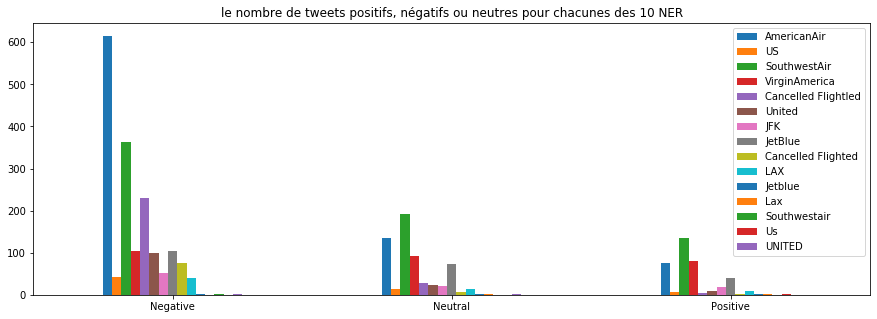

In [788]:
df_req = pd.DataFrame(freqs_ner)
df_req.index = ["Negative","Neutral","Positive"]
df_req.plot.bar(figsize=(15,5),rot=0)
plt.title("le nombre de tweets positifs, négatifs ou neutres pour chacunes des 10 NER")

Tout comme le diagramme fait à la question 11, cela aide énormément les compagnies aériennes à analyser leurs points faibles et points forts afin d'atteindre une certaine satisfaction des clients (passagers). En effet, par le biais de ce diagramme, nous pouvons déduire de prime à bord que le nombre de commentaires négatifs et largement supérieur au nombre de commentaires positifs ou neutres. Cela est très remarqué pour les deux compagnies AmericanAir et SouthwestAir. En même temps, la copagnie SouthwestAir connait le meilleur nombre de commentaires positifs et neutres dans la liste. Ce qui serait intéressant et de mesurer le ratio entre les commentaire négatifs et positifs/neutres afin d'avoir une métrique de comparaison entre les différentes compagnies aériennes.

##### Question Bonus 2. Générez une table similaire à la question 12 pour le top 10 des NER pour chaque compagnie. (1 point)

Que peut-on conclure de ces résultats?

In [ ]:
# TODO